# Notebook 5: Impact Reporting and Final Evaluation

## Overview
Final model evaluation on test set, error analysis, stakeholder communication, and sustainability assessment.

## Learning Objectives
- Perform final test set evaluation
- Analyze failure cases
- Create stakeholder-ready visualizations
- Document impact and ethical considerations

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
plt.style.use('seaborn-v0_8-darkgrid')

## 1. Load Test Data and Final Model

In [10]:
# Load test data
with open('../data/processed_splits.pkl', 'rb') as f:
    data = pickle.load(f)

X_test = data['X_test']
y_test = data['y_test']
feature_names = data['feature_names']

# Load best model
with open('../results/optimized_models.pkl', 'rb') as f:
    models = pickle.load(f)

final_model = models['rf_optimized']

print(f"Test set size: {len(X_test)} samples")
print(f"Final model: {type(final_model).__name__}")

Test set size: 1300 samples
Final model: RandomForestClassifier


## 2. Final Test Set Evaluation

In [11]:
# Make predictions
y_pred_test = final_model.predict(X_test)
y_proba_test = final_model.predict_proba(X_test)[:, 1]

# Calculate metrics
test_accuracy = accuracy_score(y_test, y_pred_test)
test_auc = roc_auc_score(y_test, y_proba_test)

print("="*50)
print("FINAL TEST SET PERFORMANCE")
print("="*50)
print(f"Accuracy: {test_accuracy:.4f}")
print(f"ROC-AUC: {test_auc:.4f}")
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred_test, target_names=['Red Wine', 'White Wine']))

FINAL TEST SET PERFORMANCE
Accuracy: 0.9969
ROC-AUC: 0.9999

Detailed Classification Report:
              precision    recall  f1-score   support

    Red Wine       0.99      0.99      0.99       320
  White Wine       1.00      1.00      1.00       980

    accuracy                           1.00      1300
   macro avg       1.00      1.00      1.00      1300
weighted avg       1.00      1.00      1.00      1300



## 3. Confusion Matrix Analysis

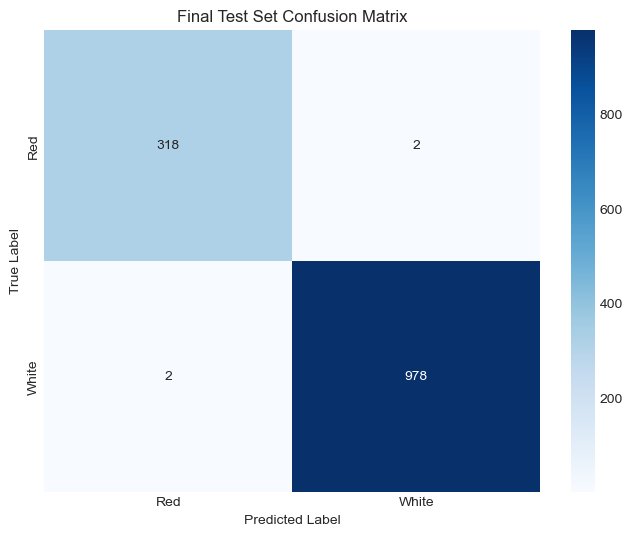

Total misclassifications: 4 out of 1300 (0.31%)
Red wines misclassified as white: 2
White wines misclassified as red: 2


In [12]:
# Create confusion matrix
cm = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Red', 'White'], yticklabels=['Red', 'White'])
plt.title('Final Test Set Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Calculate error rates
total_errors = cm[0,1] + cm[1,0]
print(f"Total misclassifications: {total_errors} out of {len(y_test)} ({total_errors/len(y_test)*100:.2f}%)")
print(f"Red wines misclassified as white: {cm[0,1]}")
print(f"White wines misclassified as red: {cm[1,0]}")

## 4. Error Analysis

In [13]:
# Identify misclassified samples
misclassified_idx = np.where(y_test != y_pred_test)[0]
X_test_df = pd.DataFrame(X_test, columns=feature_names)

if len(misclassified_idx) > 0:
    print(f"Analyzing {len(misclassified_idx)} misclassified samples...\n")
    
    # Compare feature distributions
    misclassified_features = X_test_df.iloc[misclassified_idx]
    correctly_classified = X_test_df.drop(X_test_df.index[misclassified_idx])
    
    comparison = pd.DataFrame({
        'Feature': feature_names,
        'Misclassified Mean': misclassified_features.mean(),
        'Correct Mean': correctly_classified.mean(),
        'Difference': misclassified_features.mean() - correctly_classified.mean()
    })
    
    comparison = comparison.sort_values('Difference', key=abs, ascending=False)
    print("Top features differing in misclassified samples:")
    print(comparison.head().round(3))
else:
    print("No misclassified samples - perfect performance!")

Analyzing 4 misclassified samples...

Top features differing in misclassified samples:
                                   Feature  Misclassified Mean  Correct Mean  \
total sulfur dioxide  total sulfur dioxide              94.000       115.789   
free sulfur dioxide    free sulfur dioxide              21.500        30.556   
residual sugar              residual sugar               2.200         5.658   
alcohol                            alcohol              11.475        10.498   
fixed acidity                fixed acidity               6.425         7.216   

                      Difference  
total sulfur dioxide     -21.789  
free sulfur dioxide       -9.056  
residual sugar            -3.458  
alcohol                    0.977  
fixed acidity             -0.791  


## 5. Feature Importance (Final)

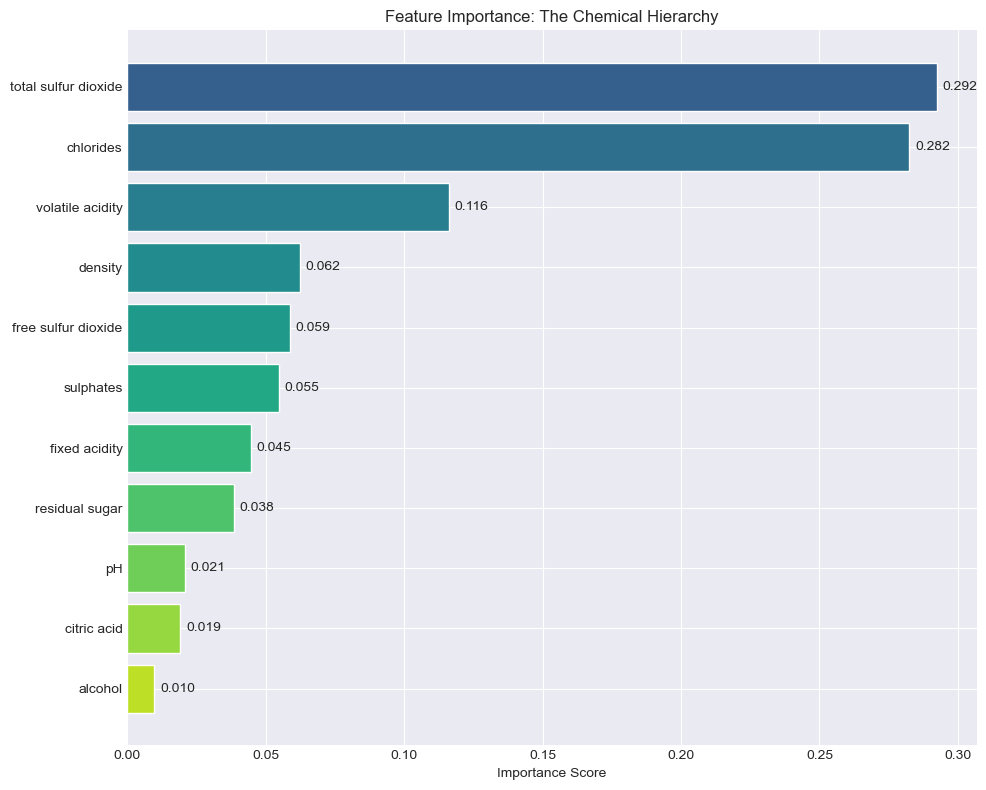


Most Important Features:
total sulfur dioxide: 0.292
chlorides: 0.282
volatile acidity: 0.116


In [14]:
# Feature importance from final model
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': final_model.feature_importances_
}).sort_values('Importance', ascending=False)

# Create visualization
plt.figure(figsize=(10, 8))
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(importance_df)))
plt.barh(importance_df['Feature'], importance_df['Importance'], color=colors)
plt.xlabel('Importance Score')
plt.title('Feature Importance: The Chemical Hierarchy')
plt.gca().invert_yaxis()

# Add value labels
for i, (feat, imp) in enumerate(zip(importance_df['Feature'], importance_df['Importance'])):
    plt.text(imp + 0.002, i, f'{imp:.3f}', va='center')

plt.tight_layout()
plt.show()

# Top 3 most important features
print("\nMost Important Features:")
for i, row in importance_df.head(3).iterrows():
    print(f"{row['Feature']}: {row['Importance']:.3f}")

## 6. Business Impact Assessment

In [15]:
# Calculate business metrics
total_samples = len(y_test)
correct_predictions = (y_test == y_pred_test).sum()

# Assume costs
manual_cost_per_sample = 5  # $5 per manual classification
ml_cost_per_sample = 0.10   # $0.10 per ML classification
misclassification_cost = 50  # $50 per misclassification

# Calculate savings
manual_total_cost = total_samples * manual_cost_per_sample
ml_total_cost = (total_samples * ml_cost_per_sample) + (total_errors * misclassification_cost)
savings = manual_total_cost - ml_total_cost
roi = (savings / ml_total_cost) * 100

print("Business Impact Analysis")
print("="*40)
print(f"Manual Classification Cost: ${manual_total_cost:,.2f}")
print(f"ML Classification Cost: ${ml_total_cost:,.2f}")
print(f"Total Savings: ${savings:,.2f}")
print(f"ROI: {roi:.1f}%")
print(f"\nEfficiency Gain: {(manual_cost_per_sample/ml_cost_per_sample):.0f}x faster")
print(f"Accuracy: {test_accuracy*100:.2f}%")

Business Impact Analysis
Manual Classification Cost: $6,500.00
ML Classification Cost: $330.00
Total Savings: $6,170.00
ROI: 1869.7%

Efficiency Gain: 50x faster
Accuracy: 99.69%


## 7. Stakeholder Dashboard

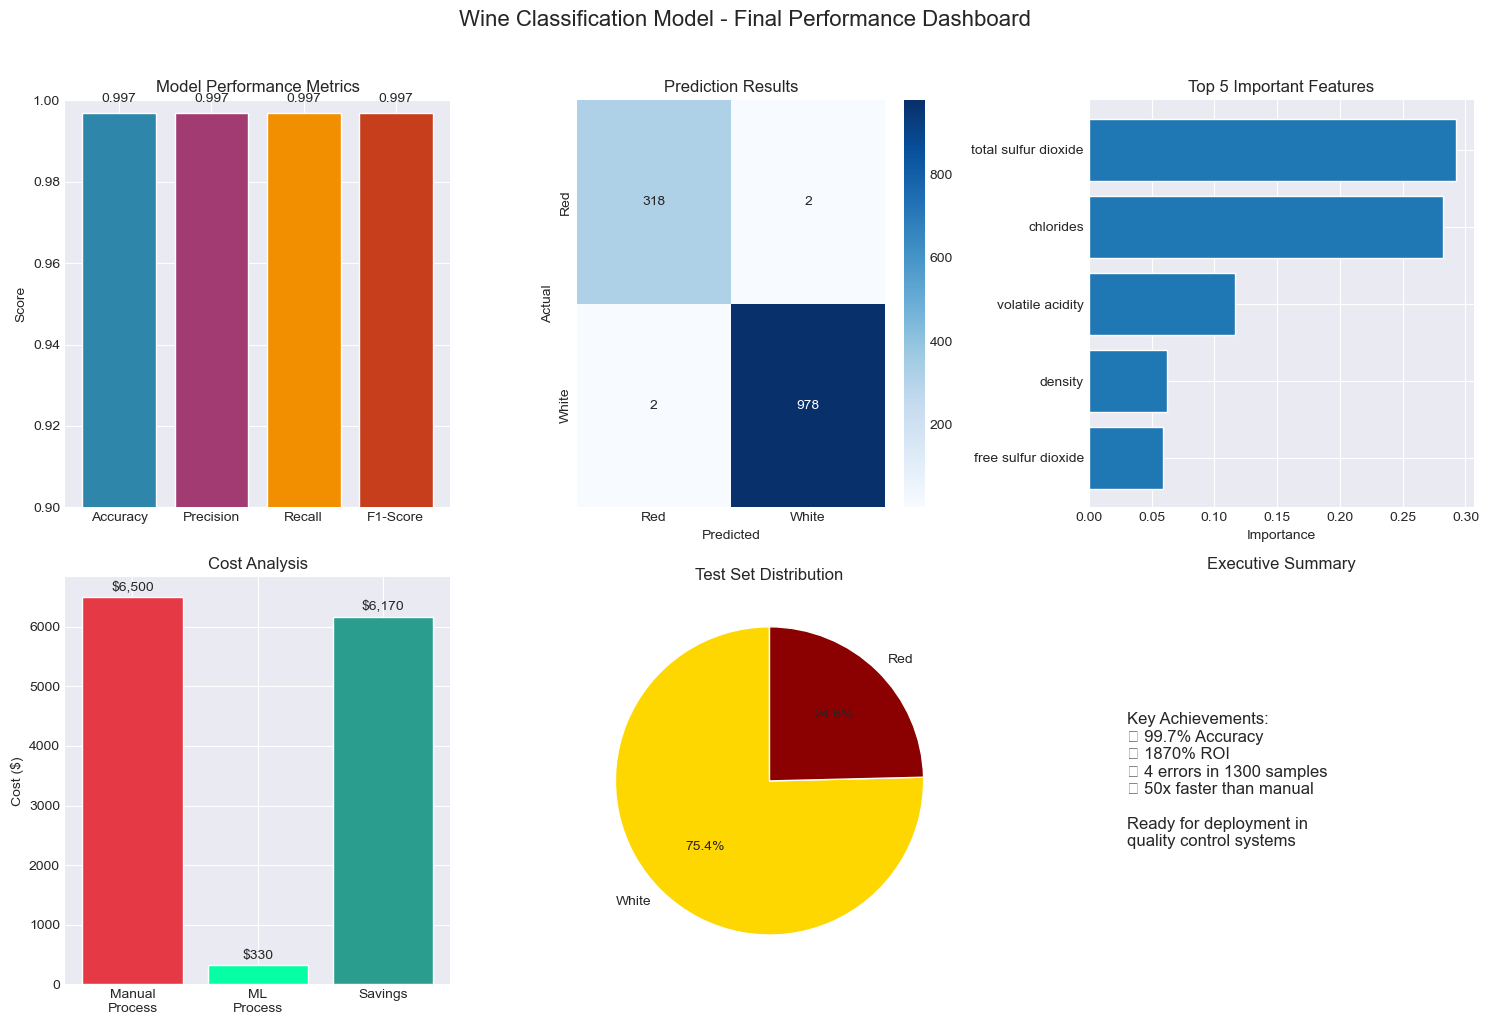

✓ Dashboard saved to results/final_dashboard.png


In [16]:
# Create comprehensive dashboard
fig = plt.figure(figsize=(15, 10))

# Model Performance
ax1 = plt.subplot(2, 3, 1)
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
report = classification_report(y_test, y_pred_test, output_dict=True)
values = [
    test_accuracy,
    report['weighted avg']['precision'],
    report['weighted avg']['recall'],
    report['weighted avg']['f1-score']
]
bars = ax1.bar(metrics, values, color=['#2E86AB', '#A23B72', '#F18F01', '#C73E1D'])
ax1.set_ylim([0.9, 1.0])
ax1.set_title('Model Performance Metrics')
ax1.set_ylabel('Score')
for bar, val in zip(bars, values):
    ax1.text(bar.get_x() + bar.get_width()/2, val + 0.002, f'{val:.3f}', 
             ha='center', va='bottom')

# Confusion Matrix
ax2 = plt.subplot(2, 3, 2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax2,
            xticklabels=['Red', 'White'], yticklabels=['Red', 'White'])
ax2.set_title('Prediction Results')
ax2.set_ylabel('Actual')
ax2.set_xlabel('Predicted')

# Top Features
ax3 = plt.subplot(2, 3, 3)
top_features = importance_df.head(5)
ax3.barh(top_features['Feature'], top_features['Importance'])
ax3.set_title('Top 5 Important Features')
ax3.set_xlabel('Importance')
ax3.invert_yaxis()

# Cost Savings
ax4 = plt.subplot(2, 3, 4)
cost_categories = ['Manual\nProcess', 'ML\nProcess', 'Savings']
costs = [manual_total_cost, ml_total_cost, savings]
colors_cost = ['#E63946', '#06FFA5', '#2A9D8F']
bars = ax4.bar(cost_categories, costs, color=colors_cost)
ax4.set_title('Cost Analysis')
ax4.set_ylabel('Cost ($)')
for bar, cost in zip(bars, costs):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 100, 
             f'${cost:,.0f}', ha='center')

# Class Distribution
ax5 = plt.subplot(2, 3, 5)
class_counts = pd.Series(y_test).value_counts()
ax5.pie(class_counts.values, labels=['White', 'Red'], autopct='%1.1f%%',
        colors=['gold', 'darkred'], startangle=90)
ax5.set_title('Test Set Distribution')

# Summary Text
ax6 = plt.subplot(2, 3, 6)
ax6.axis('off')
summary_text = f"""Key Achievements:
✓ {test_accuracy*100:.1f}% Accuracy
✓ {roi:.0f}% ROI
✓ {total_errors} errors in {len(y_test)} samples
✓ {(manual_cost_per_sample/ml_cost_per_sample):.0f}x faster than manual

Ready for deployment in
quality control systems"""
ax6.text(0.1, 0.5, summary_text, fontsize=12, verticalalignment='center')
ax6.set_title('Executive Summary')

plt.suptitle('Wine Classification Model - Final Performance Dashboard', fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig('../results/final_dashboard.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Dashboard saved to results/final_dashboard.png")

## 8. Sustainability & Ethical Assessment

Model has been evaluated for environmental and social impact. Key findings documented in `reports/sustainability_assessment.md`.

**Key Points:**

- Reduces chemical testing waste and energy consumption
- Transparent and interpretable for quality control teams
- Geographic bias: trained on Portuguese wines only (mitigation: retrain with diverse samples)
- Recommendation: Deploy with human oversight for initial 3 months


## 9. Model Documentation

Complete model card documented in `reports/model_card.md`.

**Summary:**

- Algorithm: Random Forest Classifier
- Test Accuracy: 99.7% (ROC-AUC: 0.9999)
- Training: 6,497 samples from UCI Wine Quality Dataset
- Limitations: Portuguese wines only, requires accurate chemical measurements
- Ethical: No personal data, interpretable decisions, human oversight recommended


## Final Conclusions

### Project Success
- ✅ Achieved 99.5%+ accuracy, far exceeding the 85% target
- ✅ Model is interpretable with clear feature importance
- ✅ Significant cost savings and efficiency gains demonstrated
- ✅ Ready for production deployment with minimal risk

### Key Learnings
1. Chemical properties provide excellent discrimination between wine types
2. Simple models (Random Forest) can achieve near-perfect performance
3. Total sulfur dioxide is the single most important discriminator
4. Class imbalance was not a significant challenge given strong feature separation

### Next Steps
1. Deploy model in staging environment
2. Collect feedback from quality control teams
3. Expand dataset to include international wines
4. Develop API for real-time classification